In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from datetime import datetime
import torch
import json
import mbuild as mb
import gmso
from gmso.external.convert_networkx import to_networkx
import networkx as nx
from urllib.request import urlopen
from urllib.parse import quote
import torch.nn.functional as F
import torch
from torch import nn
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear
from sklearn.metrics import mean_squared_error
from typing import List, Optional, Union
from collections.abc import Mapping, Sequence
from typing import List, Optional, Union

import torch.utils.data
from torch.utils.data.dataloader import default_collate

from torch_geometric.data import Batch, Dataset
from torch_geometric.data.data import BaseData


import sys
sys.path.insert(1, 'egnn/models/egnn_clean')
sys.path.insert(1, 'egnn')
import qm9
from qm9 import dataset
from easydict import EasyDict as edict
from qm9 import utils as qm9_utils
from qm9.models import EGNN
import torch
from torch import nn, optim

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
COF_data_path = '/Users/kieran/iMoDELS-supplements/data/raw-data/everything.csv'
COF_data = pd.read_csv(COF_data_path, index_col=0)
COF_data = COF_data[['terminal_group_1','terminal_group_2','terminal_group_3', 'backbone', 'frac-1','frac-2','COF','intercept']]

molecules = glob.glob('/Users/kieran/terminal_groups_mixed/src/util/molecules/*.pdb')
molecules = list(set(molecules))
names2graph = {}
mol_smiles = {}
name2n_nodes = {}
name2xyz = {}
name2e_index = {}
name2mol = {}
name2x = {}

missing_mols = ['difluoromethyl', 'phenol', 'toluene']
def replace_name_graph(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return names2graph[chem_name]

def n_nodes_tuple(t1, t2):
    if t1 in missing_mols or t2 in missing_mols:
        return
    else:
        return (name2n_nodes[t1], name2n_nodes[t2])
def replace_n_nodes_tuple(row):
    return n_nodes_tuple(row['terminal_group_1'], row['terminal_group_2'])

def get_positions(t1,t2):
    if t1 in missing_mols or t2 in missing_mols:
        return
    else:
        return (name2xyz[t1], name2xyz[t2])
def replace_positions(row):
    return get_positions(row['terminal_group_1'], row['terminal_group_2'])

def replace_e_index(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        return name2e_index[chem_name]
def replace_node_att(chem_name):
    if chem_name == 'difluoromethyl' or chem_name == 'phenol' or chem_name == 'toluene':
        return
    else:
        x = torch.empty((len(elements),name2n_nodes[chem_name]), dtype=torch.int32)
        for i, p in enumerate(name2mol[chem_name].particles()):
            x[i] = element2vec[p]
        return x

def CIRconvert(ids):
    url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
    ans = urlopen(url).read().decode('utf8')
    return ans

for ids in set(COF_data['terminal_group_1']):
    try:
        mol_smiles[ids] = CIRconvert(ids)
    except:
        pass
mol_smiles['nitrophenyl'] = 'CC1=CC=C(C=C1)[N+]([O-])=O'
mol_smiles['isopropyl'] = 'CC(C)O'
mol_smiles['perfluoromethyl'] = 'CC(F)(F)F'
mol_smiles['fluorophenyl'] = 'CC1=CC=C(F)C=C1'
mol_smiles['carboxyl'] = '*C(=O)O'
mol_smiles['amino'] = 'CN'


names = ''.join(smiles.upper() for smiles in mol_smiles.values())
elements = [n for n in set(names) if n.isalpha()]


vecs = F.one_hot(torch.arange(0, 5), num_classes=5)
element2vec = {e:v for e, v in zip(elements, vecs)}
vec2element = {v:e for e, v in zip(elements, vecs)}

for m in molecules:
    mol_name = m.split('/')[-1].split('.')[0]
    if 'ch3' in mol_name:
        mol_name = mol_name.split('-')[0]
    mol = mb.load(m)
    G = to_networkx(mol.to_gmso())
    adj = nx.adjacency_matrix(G)
    names2graph[mol_name] = adj
    name2n_nodes[mol_name] = len(list(G.nodes))
    name2xyz[mol_name] = mol.xyz
    name2mol[mol_name] = mol
    e_index = torch.empty((2,mol.n_bonds), dtype=torch.int64)
    parts = {p:i for i, p in enumerate(mol.particles())}
    for i, b in enumerate(mol.bonds()):
        e_index[0,i] = parts[b[0]]
        e_index[1,i] = parts[b[1]]
    name2e_index[mol_name] = e_index
    x = torch.empty((mol.n_particles,len(elements)), dtype=torch.float32)
    for i, p in enumerate(mol.particles()):
        x[i] = element2vec[p.element.symbol]
    name2x[mol_name] = x

COF_data['n_nodes'] = COF_data.apply(replace_n_nodes_tuple,axis=1)
COF_data = COF_data.dropna()
COF_data = COF_data[(COF_data['frac-1']==.5)]
COF_data.reset_index()

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/subtopology.py:70: UserWarning: Setting a parent is potentially dangerous. Consider using Topology.add_subtopology instead
  warnings.warn(
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom C, label: None id: 140639980178400>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom H, label: None id: 140639980178688>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/gmso/core/topology.py:664: UserWarning: Non-parametrized site detected <Atom H, label: None id: 140639980178736>
  warnings.warn("Non-parametrized site detected {}".format(site))
/Users/kieran/opt/miniconda3/envs

,index,terminal_group_1,terminal_group_2,terminal_group_3,backbone,frac-1,frac-2,COF,intercept,n_nodes
0,0,acetyl,acetyl,acetyl,alkylsilane,0.5,0.5,0.140174,1.292272,"(10, 10)"
1,1,acetyl,acetyl,carboxyl,alkylsilane,0.5,0.5,0.144711,3.382495,"(10, 10)"
2,2,acetyl,acetyl,fluorophenyl,alkylsilane,0.5,0.5,0.120846,1.448256,"(10, 10)"
3,3,acetyl,acetyl,hydroxyl,alkylsilane,0.5,0.5,0.149766,2.171407,"(10, 10)"
4,4,acetyl,acetyl,isopropyl,alkylsilane,0.5,0.5,0.131951,0.748749,"(10, 10)"
...,...,...,...,...,...,...,...,...,...,...
2375,3306,phenyl,pyrrole,phenol,alkylsilane,0.5,0.5,0.125767,2.664638,"(15, 13)"
2376,3307,phenyl,pyrrole,phenyl,alkylsilane,0.5,0.5,0.127045,1.369260,"(15, 13)"
2377,3308,phenyl,pyrrole,pyrrole,alkylsilane,0.5,0.5,0.136313,1.192587,"(15, 13)"
2378,3309,phenyl,pyrrole,toluene,alkylsilane,0.5,0.5,0.142473,1.098868,"(15, 13)"


In [7]:
class PairData(Data):
    def __init__(self, edge_index_s=None, x_s=None, positions_s=None, n_nodes_s=None,edge_index_t=None, x_t=None, positions_t=None, n_nodes_t=None, y=None):
        super().__init__()
        self.edge_index_s = edge_index_s
        self.x_s = x_s
        self.positions_s = positions_s
        self.n_nodes_s = n_nodes_s

        self.edge_index_t = edge_index_t
        self.x_t = x_t
        self.positions_t = positions_t
        self.n_nodes_t = n_nodes_t

        self.y = y

    # def __inc__(self, key, value, *args, **kwargs):
    #     if key == 'edge_index_s':
    #         return self.x_s.size(0)
    #     if key == 'edge_index_t':
    #         return self.x_t.size(0)
    #     else:
    #         return super().__inc__(key, value, *args, **kwargs)

class TribologyDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return glob.glob('/Users/kieran/terminal_groups_mixed/src/util/molecules/*.pdb')

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = []
        nodes_s, edges_s, nodes_t, edges_t = [], [], [], []
        for i, row in COF_data.iterrows():
            nodes_s.append(name2n_nodes[row.terminal_group_1])
            nodes_t.append(name2n_nodes[row.terminal_group_2])
            edges_s.append(name2e_index[row.terminal_group_1])
            edges_t.append(name2e_index[row.terminal_group_2])
        max_edges_s = max([e_i.size()[1] for e_i in edges_s])
        max_edges_t = max([e_i.size()[1] for e_i in edges_t])
        max_nodes_s = max(nodes_s)
        max_nodes_t = max(nodes_t)
        
        for i, row in COF_data.iterrows():  # Iterate in batches over the training dataset.
            if row.terminal_group_1 in missing_mols or row.terminal_group_2 in missing_mols:
                continue

            x_s = torch.tensor(name2x[row.terminal_group_1])
            # x_s = F.pad(x_s, (0,0,0,max_nodes_s-x_s.size()[0]))
            edge_index_s = name2e_index[row.terminal_group_1]
            # edge_index_s = F.pad(edge_index_s, (0, max_edges_s - edge_index_s.size()[1]))
            positions_s = torch.tensor(name2xyz[row.terminal_group_1])
            # positions_s = F.pad(positions_s, (0, 0, 0, max_nodes_s - positions_s.size()[0]))
            n_nodes_s = name2n_nodes[row.terminal_group_1]

            x_t = torch.tensor(name2x[row.terminal_group_2])
            # x_t = F.pad(x_t, (0,0,0,max_nodes_t-x_t.size()[0]))
            edge_index_t = name2e_index[row.terminal_group_2]
            # edge_index_t = F.pad(edge_index_t, (0, max_edges_t - edge_index_t.size()[1]))
            positions_t = torch.tensor(name2xyz[row.terminal_group_2])
            # positions_t = F.pad(positions_t, (0, 0, 0, max_nodes_t - positions_t.size()[0]))
            n_nodes_t = name2n_nodes[row.terminal_group_2]
            # print('x_s:{}, x_t:{}, e_s:{}, e_t:{}, p_s:{}, p_t:{}'.format(x_s.size(),x_t.size(),edge_index_s.size(), edge_index_t.size(),positions_s.size(),positions_t.size()))


            data = PairData(edge_index_s, x_s, positions_s, n_nodes_s, edge_index_t, x_t, positions_t, n_nodes_t,  y = torch.tensor(row.COF))
            data_list.append(data)
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

class MLP(nn.Module):
    """ a simple 4-layer MLP """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )

    def forward(self, x):
        return self.net(x)

class GCL_basic(nn.Module):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self):
        super(GCL_basic, self).__init__()


    def edge_model(self, source, target, edge_attr):
        pass

    def node_model(self, h, edge_index, edge_attr):
        pass

    def forward(self, x, edge_index, edge_attr=None):
        row, col = edge_index
        edge_feat = self.edge_model(x[row], x[col], edge_attr)
        x = self.node_model(x, edge_index, edge_feat)
        return x, edge_feat

class GCL(GCL_basic):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_nf=0, act_fn=nn.ReLU(), bias=True, attention=False, t_eq=False, recurrent=True):
        super(GCL, self).__init__()
        self.attention = attention
        self.t_eq=t_eq
        self.recurrent = recurrent
        input_edge_nf = input_nf * 2
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge_nf + edges_in_nf, hidden_nf, bias=bias),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf, bias=bias),
            act_fn)
        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(input_nf, hidden_nf, bias=bias),
                act_fn,
                nn.Linear(hidden_nf, 1, bias=bias),
                nn.Sigmoid())


        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf, hidden_nf, bias=bias),
            act_fn,
            nn.Linear(hidden_nf, output_nf, bias=bias))

        #if recurrent:
            #self.gru = nn.GRUCell(hidden_nf, hidden_nf)


    def edge_model(self, source, target, edge_attr):
        edge_in = torch.cat([source, target], dim=1)
        if edge_attr is not None:
            edge_in = torch.cat([edge_in, edge_attr], dim=1)
        out = self.edge_mlp(edge_in)
        if self.attention:
            att = self.att_mlp(torch.abs(source - target))
            out = out * att
        return out

    def node_model(self, h, edge_index, edge_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=h.size(0))
        out = torch.cat([h, agg], dim=1)
        out = self.node_mlp(out)
        if self.recurrent:
            out = out + h
            #out = self.gru(out, h)
        return out

class GCL_rf(GCL_basic):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, nf=64, edge_attr_nf=0, reg=0, act_fn=nn.LeakyReLU(0.2), clamp=False):
        super(GCL_rf, self).__init__()

        self.clamp = clamp
        layer = nn.Linear(nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
        self.phi = nn.Sequential(nn.Linear(edge_attr_nf + 1, nf),
                                 act_fn,
                                 layer)
        self.reg = reg

    def edge_model(self, source, target, edge_attr):
        x_diff = source - target
        radial = torch.sqrt(torch.sum(x_diff ** 2, dim=1)).unsqueeze(1)
        e_input = torch.cat([radial, edge_attr], dim=1)
        e_out = self.phi(e_input)
        m_ij = x_diff * e_out
        if self.clamp:
            m_ij = torch.clamp(m_ij, min=-100, max=100)
        return m_ij

    def node_model(self, x, edge_index, edge_attr):
        row, col = edge_index
        agg = unsorted_segment_mean(edge_attr, row, num_segments=x.size(0))
        x_out = x + agg - x*self.reg
        return x_out

class E_GCL(nn.Module):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_att_dim=0, act_fn=nn.ReLU(), recurrent=True, coords_weight=1.0, attention=False, clamp=False, norm_diff=False, tanh=False):
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.coords_weight = coords_weight
        self.recurrent = recurrent
        self.attention = attention
        self.norm_diff = norm_diff
        self.tanh = tanh
        edge_coords_nf = 1


        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        self.clamp = clamp
        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
            self.coords_range = nn.Parameter(torch.ones(1))*3
        self.coord_mlp = nn.Sequential(*coord_mlp)


        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

        #if recurrent:
        #    self.gru = nn.GRUCell(hidden_nf, hidden_nf)


    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        out = self.node_mlp(agg)
        if self.recurrent:
            out = x + out
        return out, agg

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        trans = torch.clamp(trans, min=-100, max=100) #This is never activated but just in case it case it explosed it may save the train
        agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        coord += agg*self.coords_weight
        return coord


    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        radial = torch.sum((coord_diff)**2, 1).unsqueeze(1)

        if self.norm_diff:
            norm = torch.sqrt(radial) + 1
            coord_diff = coord_diff/(norm)

        return radial, coord_diff

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        # coord = self.node_coord_model(h, coord)
        # x = self.node_model(x, edge_index, x[col], u, batch)  # GCN
        return h, coord, edge_attr

def unsorted_segment_sum(data, segment_ids, num_segments):
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`."""
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result

def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

class E_GCL_mask(E_GCL):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_attr_dim=0, act_fn=nn.ReLU(), recurrent=True, coords_weight=1.0, attention=False):
        E_GCL.__init__(self, input_nf, output_nf, hidden_nf, edges_in_d=edges_in_d, nodes_att_dim=nodes_attr_dim, act_fn=act_fn, recurrent=recurrent, coords_weight=coords_weight, attention=attention)

        del self.coord_mlp
        self.act_fn = act_fn

    def coord_model(self, coord, edge_index, coord_diff, edge_feat, edge_mask):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat) * edge_mask
        agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        coord += agg*self.coords_weight
        return coord

    def forward(self, h, edge_index, coord, node_mask, edge_mask, edge_attr=None, node_attr=None, n_nodes=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)

        edge_feat = edge_feat * edge_mask

        # TO DO: edge_feat = edge_feat * edge_mask

        #coord = self.coord_model(coord, edge_index, coord_diff, edge_feat, edge_mask)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, edge_attr

class EGNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=4, coords_weight=1.0, attention=False, node_attr=1):
        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers

        ### Encoder
        self.embedding = nn.Linear(in_node_nf, hidden_nf)
        self.node_attr = node_attr
        if node_attr:
            n_node_attr = in_node_nf
        else:
            n_node_attr = 0
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, E_GCL_mask(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf, nodes_attr_dim=n_node_attr, act_fn=act_fn, recurrent=True, coords_weight=coords_weight, attention=attention))

        self.node_dec = nn.Sequential(nn.Linear(self.hidden_nf, self.hidden_nf),
                                      act_fn,
                                      nn.Linear(self.hidden_nf, self.hidden_nf))

        self.graph_dec = nn.Sequential(nn.Linear(self.hidden_nf, self.hidden_nf),
                                       act_fn,
                                       nn.Linear(self.hidden_nf, 1))
        self.to(self.device)

    def forward(self, h0, x, edges, edge_attr, node_mask, edge_mask, n_nodes):
        h = self.embedding(h0)
        for i in range(0, self.n_layers):
            if self.node_attr:
                h, _, _ = self._modules["gcl_%d" % i](h, edges, x, node_mask, edge_mask, edge_attr=edge_attr, node_attr=h0, n_nodes=n_nodes)
            else:
                h, _, _ = self._modules["gcl_%d" % i](h, edges, x, node_mask, edge_mask, edge_attr=edge_attr,
                                                      node_attr=None, n_nodes=n_nodes)

        h = self.node_dec(h)
        h = h * node_mask
        h = h.view(-1, n_nodes, self.hidden_nf)
        h = torch.sum(h, dim=1)
        pred = self.graph_dec(h)
        return pred.squeeze(1)

class PairEGNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=4, coords_weight=1.0, attention=False, node_attr=1):
        super(PairEGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers

        ### Encoders
        self.embedding_s = nn.Linear(in_node_nf, hidden_nf)
        self.embedding_t = nn.Linear(in_node_nf, hidden_nf)

        self.node_attr = node_attr
        if node_attr:
            n_node_attr = in_node_nf
        else:
            n_node_attr = 0
        ### Graph convolution layers
        for i in range(0, n_layers):
            self.add_module("gcl_s_%d" % i, E_GCL_mask(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf, nodes_attr_dim=n_node_attr, act_fn=act_fn, recurrent=True, coords_weight=coords_weight, attention=attention))
            self.add_module("gcl_t_%d" % i, E_GCL_mask(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf, nodes_attr_dim=n_node_attr, act_fn=act_fn, recurrent=True, coords_weight=coords_weight, attention=attention))

        ### Decoders
        self.node_dec_s = nn.Sequential(nn.Linear(self.hidden_nf, self.hidden_nf),
                                      act_fn,
                                      nn.Linear(self.hidden_nf, self.hidden_nf))

        self.node_dec_t = nn.Sequential(nn.Linear(self.hidden_nf, self.hidden_nf),
                                act_fn,
                                nn.Linear(self.hidden_nf, self.hidden_nf))

        self.graph_dec = nn.Sequential(nn.Linear(2*self.hidden_nf, 2*self.hidden_nf),
                                       act_fn,
                                       nn.Linear(2*self.hidden_nf, 1))
        self.to(self.device)

    def forward(self, h0_s, h0_t, edges_s, edges_t, edge_attr, node_mask_s, edge_mask_s, n_nodes_s, node_mask_t, edge_mask_t, n_nodes_t, x_s, x_t):
        h_s = self.embedding_s(h0_s)
        h_t = self.embedding_t(h0_t)

        for i in range(0, self.n_layers):
            if self.node_attr:
                h_s, _, _ = self._modules["gcl_s_%d" % i](h_s, edges_s, x_s, node_mask_s, edge_mask_s, edge_attr=edge_attr, node_attr=h0_s, n_nodes=n_nodes_s)
                h_t, _, _ = self._modules["gcl_t_%d" % i](h_t, edges_t, x_t, node_mask_t, edge_mask_t, edge_attr=edge_attr, node_attr=h0_t, n_nodes=n_nodes_t)
            else:
                h_s, _, _ = self._modules["gcl_s_%d" % i](h_s, edges_s, x_s, node_mask_s, edge_mask_s, edge_attr=edge_attr,
                                                      node_attr=None, n_nodes=n_nodes_s)
                h_t, _, _ = self._modules["gcl_t_%d" % i](h_t, edges_t, x_t, node_mask_t, edge_mask_t, edge_attr=edge_attr,
                                                      node_attr=None, n_nodes=n_nodes_t)

        h_s = self.node_dec_s(h_s)
        h_s = h_s * node_mask_s
        h_s = h_s.view(-1, n_nodes_s, self.hidden_nf)
        h_s = torch.sum(h_s, dim=1)

        h_t = self.node_dec_t(h_t)
        h_t = h_t * node_mask_t
        h_t = h_t.view(-1, n_nodes_t, self.hidden_nf)
        h_t = torch.sum(h_t, dim=1)

        pred = self.graph_dec(torch.cat((h_s,h_t), dim=1))
        return pred.squeeze(1)

In [40]:
import torch_geometric as tg


dataloaders, charge_scale = dataset.retrieve_dataloaders(8, 2)
dat = TribologyDataset(root='.')

dat.shuffle()
train_dataset = dat[:2000]
test_dataset = dat[2000:]
train_loader = DataLoader(train_dataset, batch_size=2, follow_batch=['x_s', 'x_t', 'positions_s','positions_t'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, follow_batch=['x_s', 'x_t'], shuffle=False)
device = torch.device("cpu")

edges_dic = {}
def get_adj_matrix(n_nodes, batch_size, device):
    if n_nodes in edges_dic:
        edges_dic_b = edges_dic[n_nodes]
        if batch_size in edges_dic_b:
            return edges_dic_b[batch_size]
        else:
            # get edges for a single sample
            rows, cols = [], []
            for batch_idx in range(batch_size):
                for i in range(n_nodes):
                    for j in range(n_nodes):
                        rows.append(i + batch_idx*n_nodes)
                        cols.append(j + batch_idx*n_nodes)

    else:
        edges_dic[n_nodes] = {}
        return get_adj_matrix(n_nodes, batch_size, device)

    edges = [torch.LongTensor(rows).to(device), torch.LongTensor(cols).to(device)]
    return edges

def preprocess_input(one_hot, charges, charge_power, charge_scale, device):
    charge_tensor = (charges.unsqueeze(-1) / charge_scale).pow(
        torch.arange(charge_power + 1., device=device, dtype=torch.float32))
    charge_tensor = charge_tensor.view(charges.shape + (1, charge_power + 1))
    atom_scalars = (one_hot.unsqueeze(-1) * charge_tensor).view(charges.shape[:2] + (-1,))
    return atom_scalars

for i, data in enumerate(zip(dataloaders['train'], train_loader)):
    batch_size, n_nodes, _ = data[0]['positions'].size()
    # atom_positions = data[0]['positions'].view(batch_size * n_nodes, -1)
    # atom_mask = data[0]['atom_mask'].view(batch_size * n_nodes, -1)
    # edge_mask = data[0]['edge_mask']
    # one_hot = data[0]['one_hot']
    # charges = data[0]['charges']
    # nodes = qm9_utils.preprocess_input(one_hot, charges, args.charge_power, charge_scale, device)

    # nodes = nodes.view(batch_size * n_nodes, -1)
    # nodes = torch.cat([one_hot, charges], dim=1)
    row, col = qm9_utils.get_adj_matrix(n_nodes, batch_size, device)
    row, col = get_adj_matrix(17, 8,device)
    
    
    dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data[1].positions_s, data[1].positions_s_batch)
    dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data[1].positions_t, data[1].positions_t_batch)
    batch_size_s, n_nodes_s, _ = dense_positions_s.size()
    batch_size_t, n_nodes_t, _ = dense_positions_t.size()
    atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1)
    atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1)
    edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
    #mask diagonal
    diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_s *= diag_mask
    edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1)
    edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
    edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
    #mask diagonal
    diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
    edge_mask_t *= diag_mask
    edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t, n_nodes_t, 1)

    atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1)
    atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1)

    one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data[1].x_s, data[1].x_s_batch)
    one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data[1].x_t, data[1].x_t_batch)
    one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1)
    one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1)
    edges_s = qm9_utils.get_adj_matrix(n_nodes_s, batch_size_s, device)
    edges_t = qm9_utils.get_adj_matrix(n_nodes_t, batch_size_t, device)

    
    print('pos size', atom_positions_s.size())
    print('atommask size', atom_mask_s.size())
    print('edgemask size', edge_mask_s.size())
    print('one_hot size', one_hot_s.size())
    print('row size', type(edges_s[0]))

    break

pos size torch.Size([20, 3])
atommask size torch.Size([20, 1])
edgemask size torch.Size([2, 10, 10])
one_hot size torch.Size([20, 5])
row size <class 'torch.Tensor'>


In [29]:
from qm9 import dataset
from qm9.models import EGNN
import torch
from torch import nn, optim
import argparse
from qm9 import utils as qm9_utils
import utils
import json
from easydict import EasyDict as edict
import torch_geometric as tg

n_epochs  = 30

device = torch.device("cpu")
dtype = torch.float32

dat = TribologyDataset(root='.')

batch_size = 64

dat.shuffle()
train_dataset = dat[:2000]
test_dataset = dat[2000:]
train_loader = DataLoader(train_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, follow_batch=['x_s', 'x_t', 'positions_s', 'positions_t'], shuffle=False)

def compute_cof_mean_mad(data):
    values = torch.Tensor(data['COF'])
    mean = torch.mean(values)
    ma = torch.abs(values - mean)
    mad = torch.mean(ma)
    return mean, mad

prop_mean, prop_mad = compute_cof_mean_mad(COF_data)

model = PairEGNN(in_node_nf=5, in_edge_nf=0, hidden_nf=64, device=device, n_layers=4, coords_weight=1.0,
             attention=False, node_attr=1)

print(model)

optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-16)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
criterion = torch.nn.MSELoss()


def train(epoch, loader):
    epoch_loss = 0
    lr_scheduler.step()
    model.train()

    for i, data in enumerate(loader):
        dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
        dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
        batch_size_s, n_nodes_s, _ = dense_positions_s.size()
        batch_size_t, n_nodes_t, _ = dense_positions_t.size()
        atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
        atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)

        edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_s *= diag_mask
        edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
        edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_t *= diag_mask
        edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)

        atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
        atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)

        one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
        one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
        one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
        one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
        edges_s = qm9_utils.get_adj_matrix(n_nodes_s, batch_size_s, device)
        edges_t = qm9_utils.get_adj_matrix(n_nodes_t, batch_size_t, device)
        label = data.y.to(device, dtype)

        pred = model(h0_s=one_hot_s, h0_t=one_hot_t, edges_s=edges_s, edges_t=edges_t, edge_attr=None, node_mask_s=atom_mask_s, 
                    edge_mask_s=edge_mask_s, n_nodes_s=n_nodes_s, node_mask_t=atom_mask_t, edge_mask_t=edge_mask_t, 
                    n_nodes_t=n_nodes_t, x_s=atom_positions_s, x_t=atom_positions_t)


        loss = criterion(pred, label)  # Compute the loss.
        epoch_loss += loss.item()
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        if i % 10 == 0:
            print("Epoch %d \t Iteration %d \t loss %.4f" % (epoch, i, loss.item()))
    return epoch_loss
    
def test(loader):
    model.eval()

    squared_error = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        dense_positions_s, atom_mask_s = tg.utils.to_dense_batch(data.positions_s, data.positions_s_batch)
        dense_positions_t, atom_mask_t = tg.utils.to_dense_batch(data.positions_t, data.positions_t_batch)
        batch_size_s, n_nodes_s, _ = dense_positions_s.size()
        batch_size_t, n_nodes_t, _ = dense_positions_t.size()
        atom_positions_s = dense_positions_s.view(batch_size_s * n_nodes_s, -1).to(device, dtype)
        atom_positions_t = dense_positions_t.view(batch_size_t * n_nodes_t, -1).to(device, dtype)

        edge_mask_s = atom_mask_s.unsqueeze(1) * atom_mask_s.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_s.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_s *= diag_mask
        edge_mask_s = edge_mask_s.view(batch_size_s * n_nodes_s * n_nodes_s, 1).to(device)
        edge_mask_t = atom_mask_t.unsqueeze(1) * atom_mask_t.unsqueeze(2)
        #mask diagonal
        diag_mask = ~torch.eye(edge_mask_t.size(1), dtype=torch.bool).unsqueeze(0)
        edge_mask_t *= diag_mask
        edge_mask_t = edge_mask_t.view(batch_size_t * n_nodes_t * n_nodes_t, 1).to(device)

        atom_mask_s = atom_mask_s.view(batch_size_s * n_nodes_s, -1).to(device)
        atom_mask_t = atom_mask_t.view(batch_size_t * n_nodes_t, -1).to(device)

        one_hot_s, one_hot_s_mask = tg.utils.to_dense_batch(data.x_s, data.x_s_batch)
        one_hot_t, one_hot_s_mask = tg.utils.to_dense_batch(data.x_t, data.x_t_batch)
        one_hot_s = one_hot_s.view(batch_size_s * n_nodes_s, -1).to(device)
        one_hot_t = one_hot_t.view(batch_size_t * n_nodes_t, -1).to(device)
        edges_s = qm9_utils.get_adj_matrix(n_nodes_s, batch_size_s, device)
        edges_t = qm9_utils.get_adj_matrix(n_nodes_t, batch_size_t, device)
        label = data.y.to(device, dtype)
        pred = model(h0_s=one_hot_s, h0_t=one_hot_t, edges_s=edges_s, edges_t=edges_t, edge_attr=None, node_mask_s=atom_mask_s, 
                    edge_mask_s=edge_mask_s, n_nodes_s=n_nodes_s, node_mask_t=atom_mask_t, edge_mask_t=edge_mask_t, 
                    n_nodes_t=n_nodes_t, x_s=atom_positions_s, x_t=atom_positions_t)
        res = label - pred
        squared_error.append(torch.pow(res, 2).sum())

    return sum(squared_error) / len(squared_error)

res = {'epochs': [], 'train_loss': [],'test_loss': [], 'best_val': 1e10, 'best_test': 1e10, 'best_epoch': 0}

for epoch in range(0, n_epochs):
    train_loss = train(epoch, train_loader)
    res['train_loss'].append(train_loss)
    if epoch % 4 == 0:
        test_loss = test(test_loader)
        res['epochs'].append(epoch)
        res['test_loss'].append(test_loss.detach().numpy())

        if test_loss < res['best_val']:
            res['best_val'] = test_loss
            res['best_test'] = test_loss
            res['best_epoch'] = epoch
        print("test loss: %.4f \t epoch %d" % (test_loss, epoch))
        print("Best: val loss: %.4f \t test loss: %.4f \t epoch %d" % (res['best_val'], res['best_test'], res['best_epoch']))


    # json_object = json.dumps(res, indent=4)
    # with open(args.outf + "/" + args.exp_name + "/losess.json", "w") as outfile:
    #     outfile.write(json_object)

PairEGNN(
  (embedding_s): Linear(in_features=5, out_features=64, bias=True)
  (embedding_t): Linear(in_features=5, out_features=64, bias=True)
  (gcl_s_0): E_GCL_mask(
    (edge_mlp): Sequential(
      (0): Linear(in_features=129, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
    )
    (node_mlp): Sequential(
      (0): Linear(in_features=133, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
    (act_fn): SiLU()
  )
  (gcl_t_0): E_GCL_mask(
    (edge_mlp): Sequential(
      (0): Linear(in_features=129, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
    )
    (node_mlp): Sequential(
      (0): Linear(in_features=133, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
    (act_fn): SiLU()
  )
  (gcl_s_1):

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0 	 Iteration 0 	 loss 0.0861
Epoch 0 	 Iteration 10 	 loss 0.0072
Epoch 0 	 Iteration 20 	 loss 0.0004
Epoch 0 	 Iteration 30 	 loss 0.0008
test loss: 0.0215 	 epoch 0
Best: val loss: 0.0215 	 test loss: 0.0215 	 epoch 0
Epoch 1 	 Iteration 0 	 loss 0.0002
Epoch 1 	 Iteration 10 	 loss 0.0003
Epoch 1 	 Iteration 20 	 loss 0.0003
Epoch 1 	 Iteration 30 	 loss 0.0001
Epoch 2 	 Iteration 0 	 loss 0.0002
Epoch 2 	 Iteration 10 	 loss 0.0002
Epoch 2 	 Iteration 20 	 loss 0.0002
Epoch 2 	 Iteration 30 	 loss 0.0002
Epoch 3 	 Iteration 0 	 loss 0.0002
Epoch 3 	 Iteration 10 	 loss 0.0002
Epoch 3 	 Iteration 20 	 loss 0.0002
Epoch 3 	 Iteration 30 	 loss 0.0002
Epoch 4 	 Iteration 0 	 loss 0.0002
Epoch 4 	 Iteration 10 	 loss 0.0002
Epoch 4 	 Iteration 20 	 loss 0.0002
Epoch 4 	 Iteration 30 	 loss 0.0001
test loss: 0.0110 	 epoch 4
Best: val loss: 0.0110 	 test loss: 0.0110 	 epoch 4
Epoch 5 	 Iteration 0 	 loss 0.0001
Epoch 5 	 Iteration 10 	 loss 0.0002
Epoch 5 	 Iteration 20 	 loss 

In [30]:
plt.figure(figsize=(12,6))
plt.plot(list(range(len(res['train_loss']))), res['train_loss'],label='training')
plt.plot(res['epochs'], res['test_loss'],label='testing')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('training.png')

# Pair GNN

In [ ]:
n_elements = 5

class PairGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(PairGNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1_1 = GraphConv(n_elements, hidden_channels)
        self.conv1_2 = GraphConv(hidden_channels, hidden_channels)
        self.conv1_3 = GraphConv(hidden_channels, hidden_channels)

        self.conv2_1 = GraphConv(n_elements, hidden_channels)
        self.conv2_2 = GraphConv(hidden_channels, hidden_channels)
        self.conv2_3 = GraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(2*hidden_channels, 2*hidden_channels)
        self.lin2 = Linear(2*hidden_channels, hidden_channels)
        self.lin_final = Linear(hidden_channels, 1)

    def forward(self, x_s, edge_index_s, x_t, edge_index_t, x_s_batch, x_t_batch):
        x_s = self.conv1_1(x_s, edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv1_2(x_s, edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv1_3(x_s, edge_index_s)
        x_s = global_mean_pool(x_s, x_s_batch)
        x_s = F.dropout(x_s, p=0.5, training=self.training)

        x_t = self.conv2_1(x_t, edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv2_2(x_t, edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv2_3(x_t, edge_index_t)
        x_t = global_mean_pool(x_t, x_t_batch)
        x_t = F.dropout(x_t, p=0.5, training=self.training)

        x = torch.cat((x_s, x_t), dim=1)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin_final(x)
        
        return x

In [ ]:
n_epochs = 100
model = PairGNN(hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    epoch_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(x_s=data.x_s.float(), edge_index_s=data.edge_index_s, x_t=data.x_t.float(),
                    edge_index_t=data.edge_index_t, x_s_batch = data.x_s_batch, x_t_batch = data.x_t_batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        epoch_loss += loss
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return epoch_loss

def test(loader):
    model.eval()

    squared_error = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(x_s=data.x_s.float(), edge_index_s=data.edge_index_s, x_t=data.x_t.float(),
                    edge_index_t=data.edge_index_t, x_s_batch = data.x_s_batch, x_t_batch = data.x_t_batch)
        res = data.y - out
        
        squared_error.append(torch.pow(res, 2).sum())

    return sum(squared_error) / len(squared_error)

training_loss = []
testing_loss = []

for epoch in range(1, n_epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    training_loss.append(train_acc.detach().numpy())
    testing_loss.append(test_acc.detach().numpy())
    print(f'Epoch: {epoch:03d}, Train MSE: {train_acc:.4f}, Test MSE: {test_acc:.4f}')

/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/kieran/opt/miniconda3/envs/forward/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Train MSE: 1.9399, Test MSE: 4.5168
Epoch: 002, Train MSE: 1.2434, Test MSE: 4.8490
Epoch: 003, Train MSE: 1.1539, Test MSE: 4.7538
Epoch: 004, Train MSE: 1.5170, Test MSE: 5.2531
Epoch: 005, Train MSE: 1.5871, Test MSE: 5.3106
Epoch: 006, Train MSE: 1.0313, Test MSE: 3.7780
Epoch: 007, Train MSE: 0.9936, Test MSE: 4.0974
Epoch: 008, Train MSE: 1.4585, Test MSE: 4.6294
Epoch: 009, Train MSE: 1.1938, Test MSE: 3.9663
Epoch: 010, Train MSE: 1.0246, Test MSE: 3.5477
Epoch: 011, Train MSE: 0.8579, Test MSE: 2.9595
Epoch: 012, Train MSE: 0.8693, Test MSE: 2.6871
Epoch: 013, Train MSE: 0.9094, Test MSE: 1.9636
Epoch: 014, Train MSE: 0.8201, Test MSE: 1.9024
Epoch: 015, Train MSE: 0.7964, Test MSE: 1.6647
Epoch: 016, Train MSE: 1.0586, Test MSE: 2.0867
Epoch: 017, Train MSE: 0.7911, Test MSE: 1.5282
Epoch: 018, Train MSE: 1.0394, Test MSE: 1.8413
Epoch: 019, Train MSE: 0.8676, Test MSE: 1.5352
Epoch: 020, Train MSE: 1.1689, Test MSE: 1.8412
Epoch: 021, Train MSE: 1.3266, Test MSE:

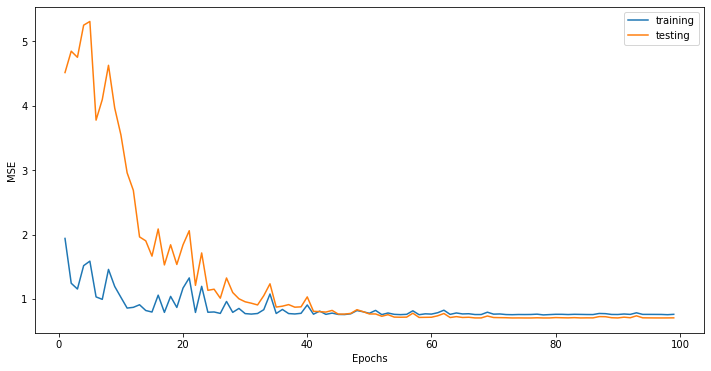

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(1, n_epochs), training_loss,label='training')
plt.plot(range(1, n_epochs), testing_loss,label='testing')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()